In [73]:
import findspark
findspark.init()
findspark.find()

'/home/hb/Downloads/spark-3.3.2-bin-hadoop3'

In [74]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('bank').getOrCreate()

In [75]:
df = spark.read.csv("ML_hw_dataset.csv", inferSchema=True, header=True)

# Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [4]:
df.show(2)

+---+-----------+-------+---------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job|marital|education|default|housing|loan| contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----------+-------+---------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 44|blue-collar|married| basic.4y|unknown|    yes|  no|cellular|  aug|        thu|     210|       1|  999|       0|nonexistent|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|
| 53| technician|married|  unknown|     no|     no|  no|cellular|  nov|        fri|     138|       1|  999|       0|nonexistent|        -0.1|          93.2|        -42.0|    4.021|     5195.8|  0|
+---+----------

In [5]:
num_rows = df.count()
num_cols = len(df.columns)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

Number of rows:  41188
Number of columns:  21


In [9]:
df.describe().show()

df.describe().toPandas()


+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+------------------+------------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|summary|               age|    job| marital|education|default|housing| loan|  contact|month|day_of_week|          duration|          campaign|             pdays|           previous|poutcome|       emp_var_rate|    cons_price_idx|     cons_conf_idx|         euribor3m|      nr_employed|                  y|
+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+------------------+------------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|  count|             41188|  41188|   41188|    41188|  41188|  41188|41188|  

,summary,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,count,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
1,mean,40.02406040594348,None,None,None,None,None,None,None,None,...,2.567592502670681,962.4754540157328,0.17296299893172767,None,0.08188550063125773,93.57566436827047,-40.50260027192026,3.6212908128583696,5167.035910943169,0.11265417111780131
2,stddev,10.421249980934075,None,None,None,None,None,None,None,None,...,2.7700135429023436,186.91090734474133,0.49490107983929066,None,1.5709597405170235,0.5788400489541238,4.628197856174545,1.7344474048512692,72.25152766826125,0.31617342694296513
3,min,17,admin.,divorced,basic.4y,no,no,no,cellular,apr,...,1,0,0,failure,-3.4,92.201,-50.8,0.634,4963.6,0
4,max,98,unknown,unknown,unknown,yes,yes,yes,telephone,sep,...,56,999,7,success,1.4,94.767,-26.9,5.045,5228.1,1


In [6]:
from pyspark.sql.functions import countDistinct

df.select([countDistinct(col).alias(col) for col in df.columns]).toPandas()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,78,12,4,8,3,3,3,2,10,5,...,42,27,8,3,10,26,26,316,11,2


In [7]:
from pyspark.sql.functions import count

education_counts = df.groupBy('education').agg(count('*').alias('count'))
education_counts.show()

education_counts = df.groupBy('job').agg(count('*').alias('count'))
education_counts.show()

education_counts = df.groupBy('age').agg(count('*').alias('count'))
education_counts.show()

education_counts = df.groupBy('marital').agg(count('*').alias('count'))
education_counts.show()

+-------------------+-----+
|          education|count|
+-------------------+-----+
|        high.school| 9515|
|            unknown| 1731|
|           basic.6y| 2292|
|professional.course| 5243|
|  university.degree|12168|
|         illiterate|   18|
|           basic.4y| 4176|
|           basic.9y| 6045|
+-------------------+-----+

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 2924|
|      retired| 1720|
|      unknown|  330|
|self-employed| 1421|
|      student|  875|
|  blue-collar| 9254|
| entrepreneur| 1456|
|       admin.|10422|
|   technician| 6743|
|     services| 3969|
|    housemaid| 1060|
|   unemployed| 1014|
+-------------+-----+

+---+-----+
|age|count|
+---+-----+
| 31| 1947|
| 85|   15|
| 65|   44|
| 53|  733|
| 78|   27|
| 34| 1745|
| 81|   20|
| 28| 1001|
| 76|   34|
| 27|  851|
| 26|  698|
| 44| 1011|
| 91|    2|
| 22|  137|
| 47|  928|
| 52|  779|
| 86|    8|
| 40| 1161|
| 20|   65|
| 94|    1|
+---+-----+
only showing top 20 ro

In [12]:
df.summary().show()

df.summary().toPandas()

+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+------------------+------------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|summary|               age|    job| marital|education|default|housing| loan|  contact|month|day_of_week|          duration|          campaign|             pdays|           previous|poutcome|       emp_var_rate|    cons_price_idx|     cons_conf_idx|         euribor3m|      nr_employed|                  y|
+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+------------------+------------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|  count|             41188|  41188|   41188|    41188|  41188|  41188|41188|  

,summary,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,count,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
1,mean,40.02406040594348,None,None,None,None,None,None,None,None,...,2.567592502670681,962.4754540157328,0.17296299893172767,None,0.08188550063125773,93.57566436827047,-40.50260027192026,3.6212908128583696,5167.035910943169,0.11265417111780131
2,stddev,10.421249980934075,None,None,None,None,None,None,None,None,...,2.7700135429023436,186.91090734474133,0.49490107983929066,None,1.5709597405170235,0.5788400489541238,4.628197856174545,1.7344474048512692,72.25152766826125,0.31617342694296513
3,min,17,admin.,divorced,basic.4y,no,no,no,cellular,apr,...,1,0,0,failure,-3.4,92.201,-50.8,0.634,4963.6,0
4,25%,32,None,None,None,None,None,None,None,None,...,1,999,0,None,-1.8,93.075,-42.7,1.344,5099.1,0
5,50%,38,None,None,None,None,None,None,None,None,...,2,999,0,None,1.1,93.749,-41.8,4.857,5191.0,0
6,75%,47,None,None,None,None,None,None,None,None,...,3,999,0,None,1.4,93.994,-36.4,4.961,5228.1,0
7,max,98,unknown,unknown,unknown,yes,yes,yes,telephone,sep,...,56,999,7,success,1.4,94.767,-26.9,5.045,5228.1,1


# EDA analysis


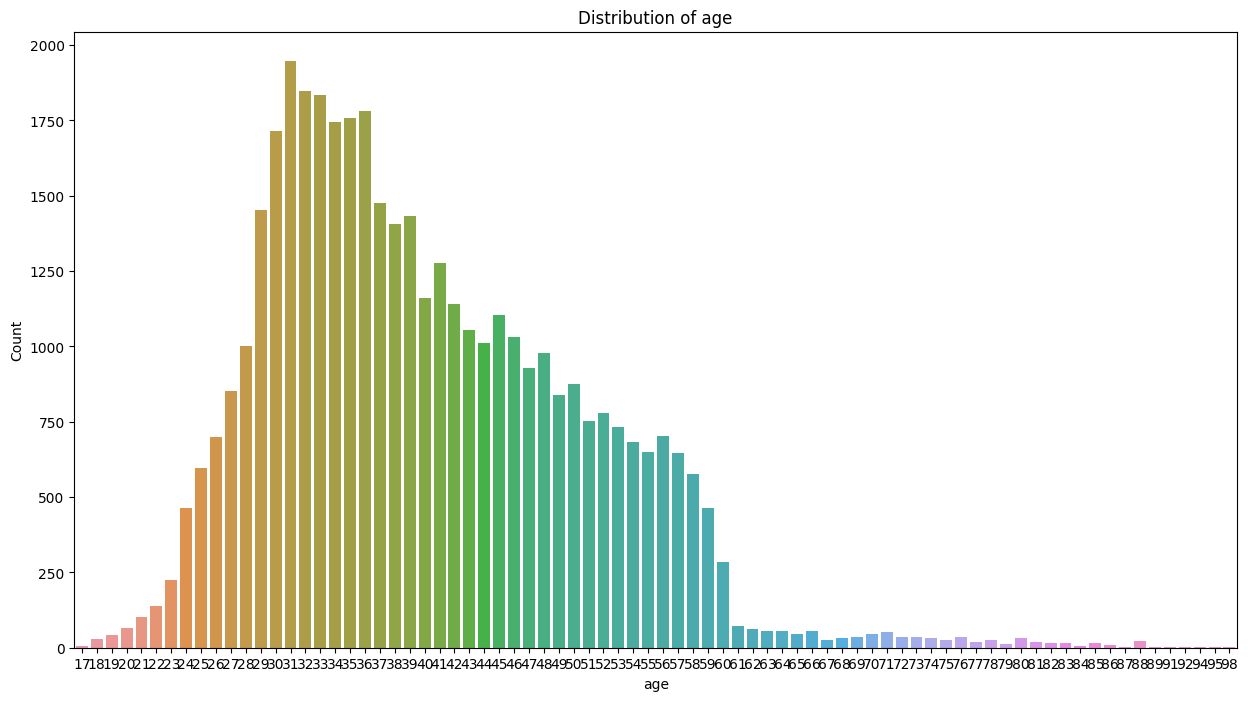

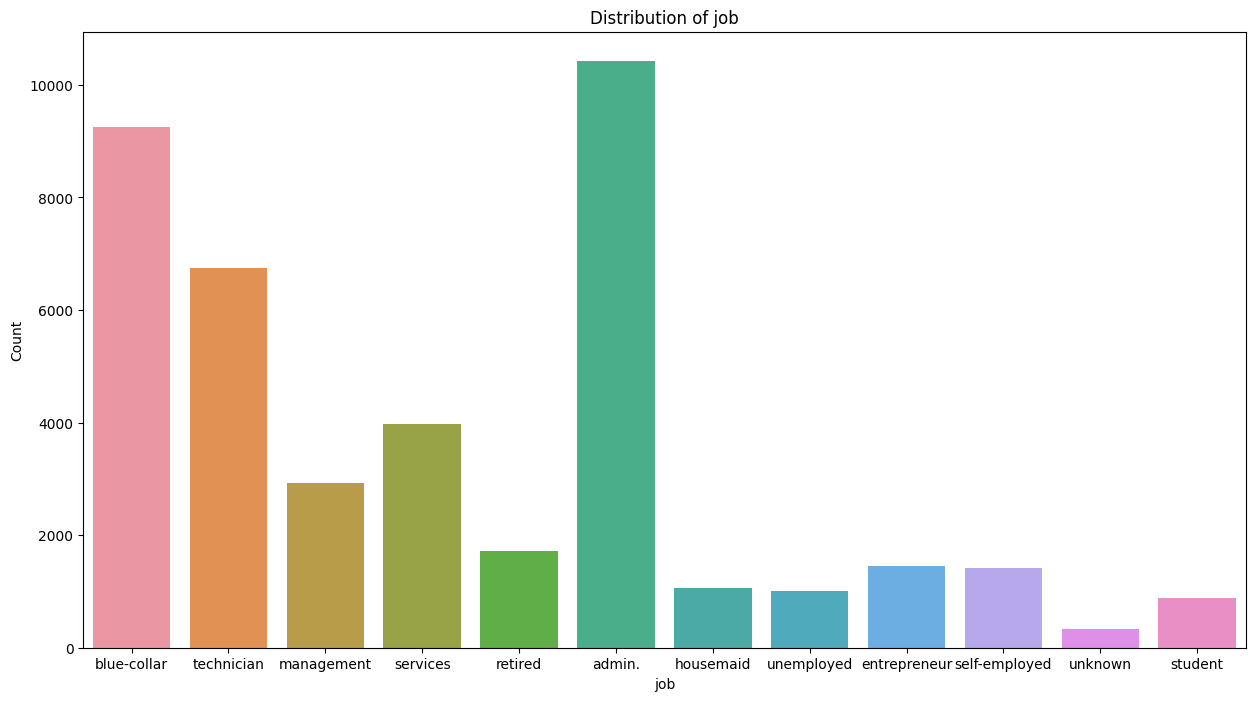

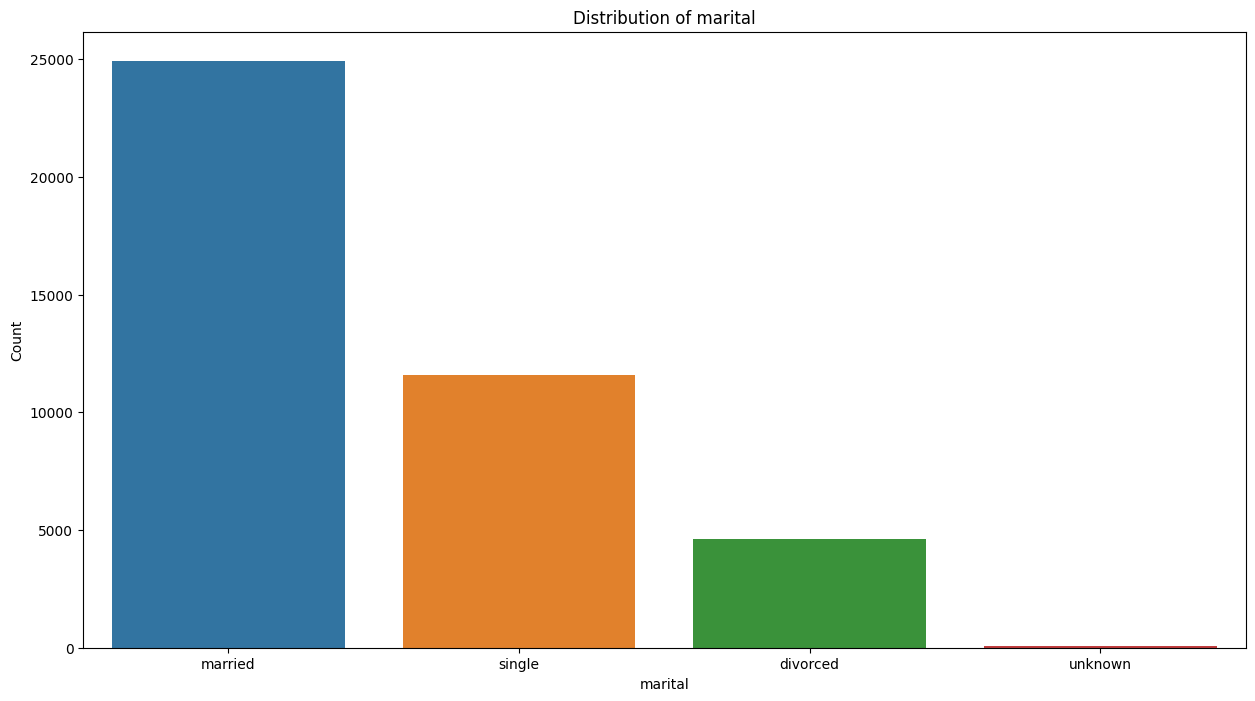

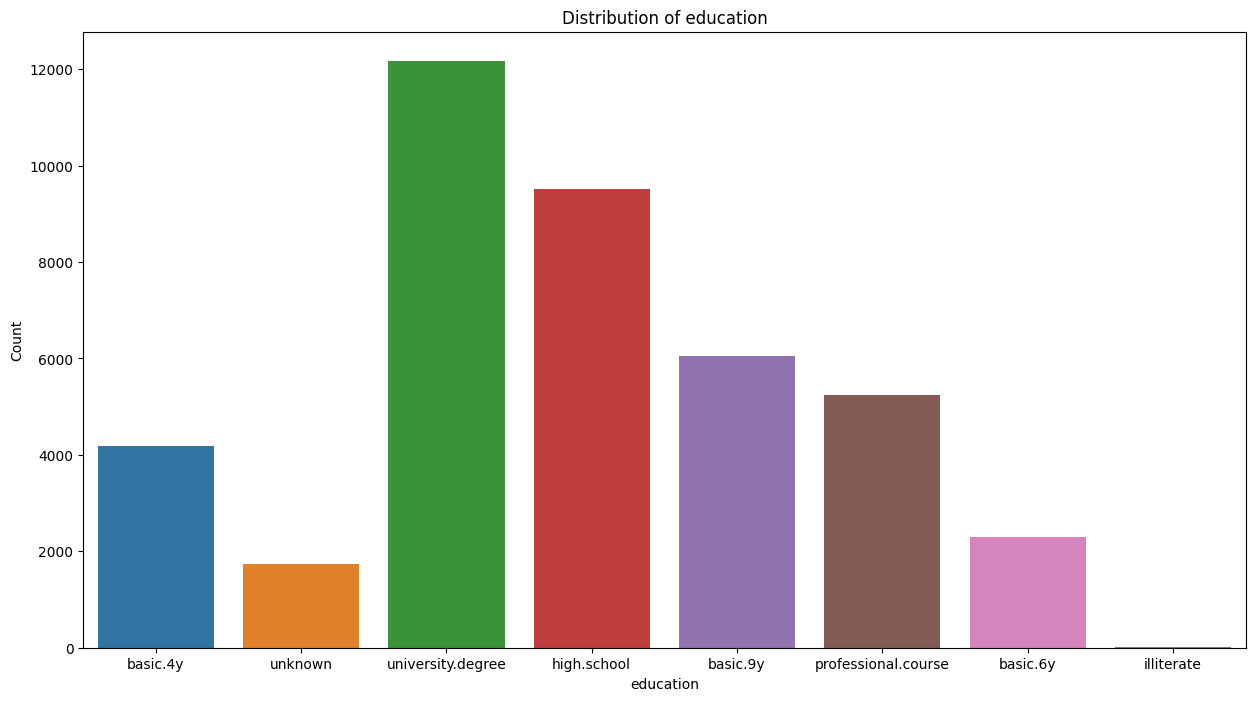

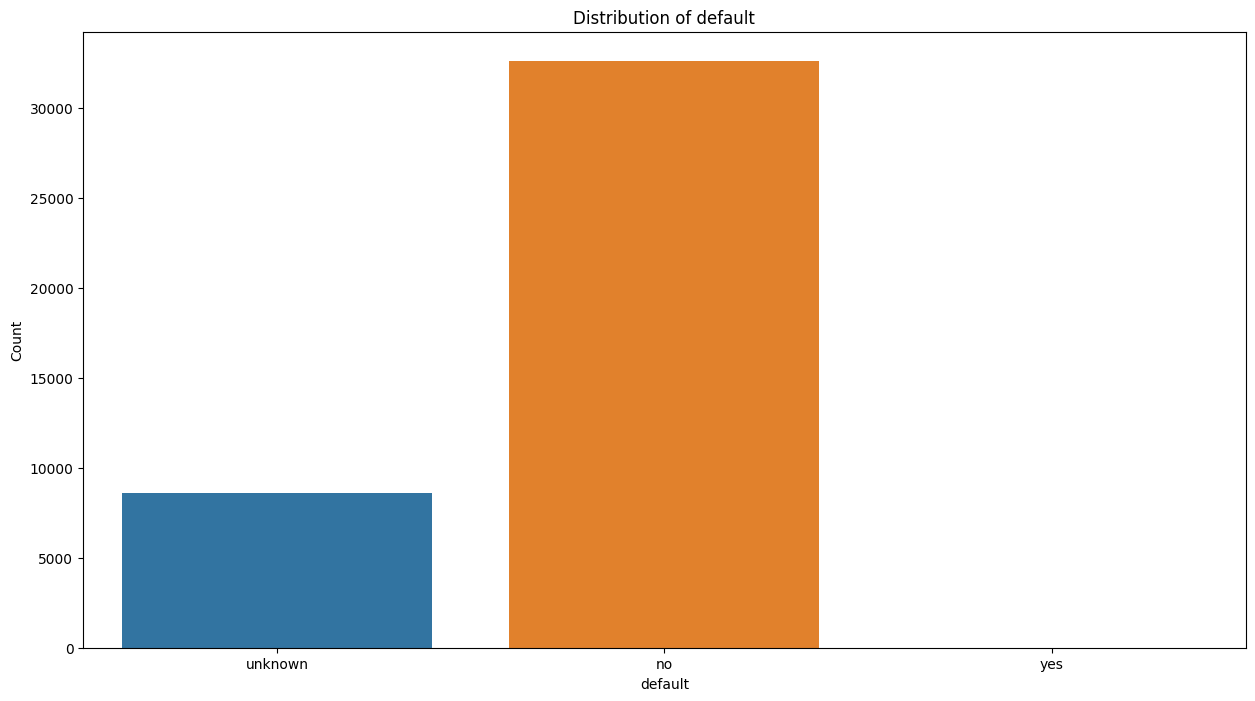

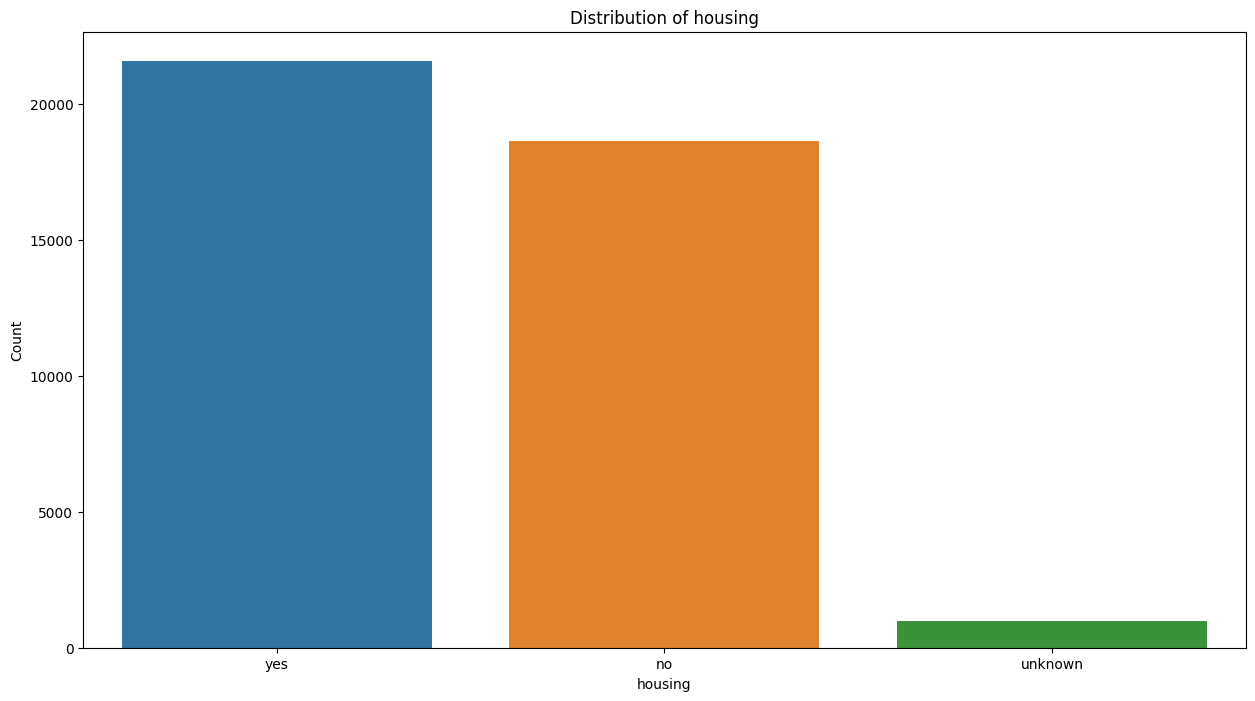

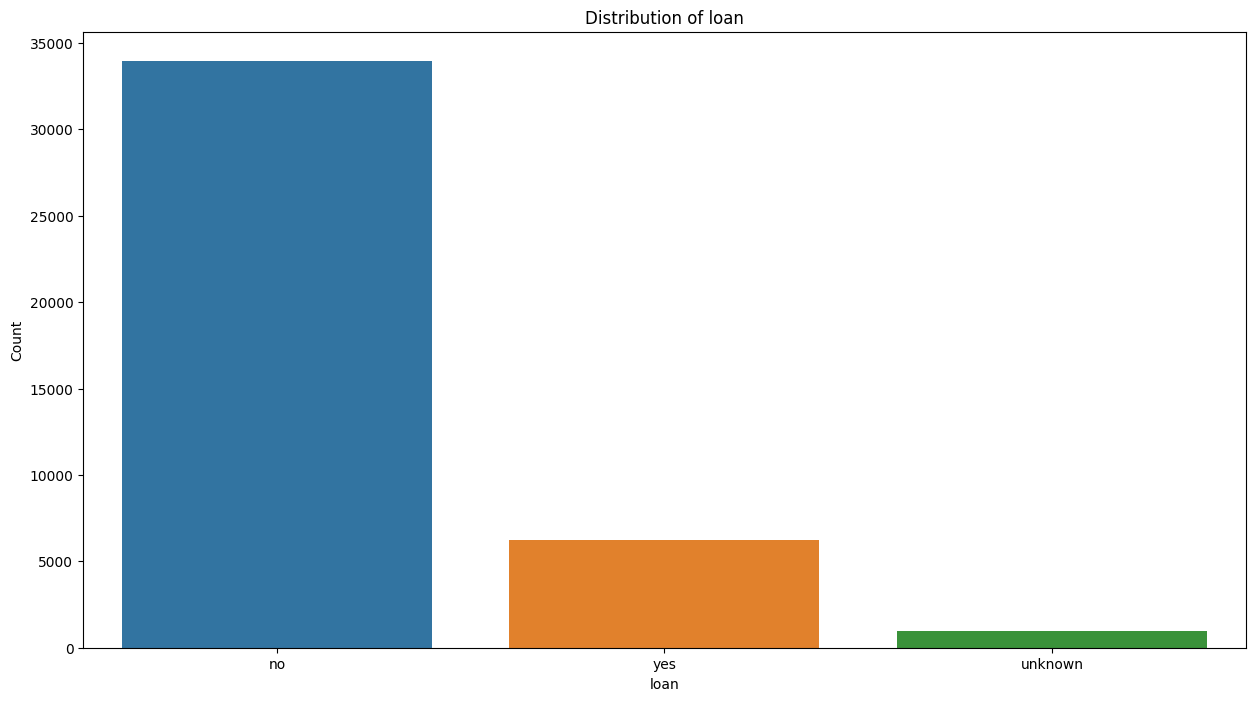

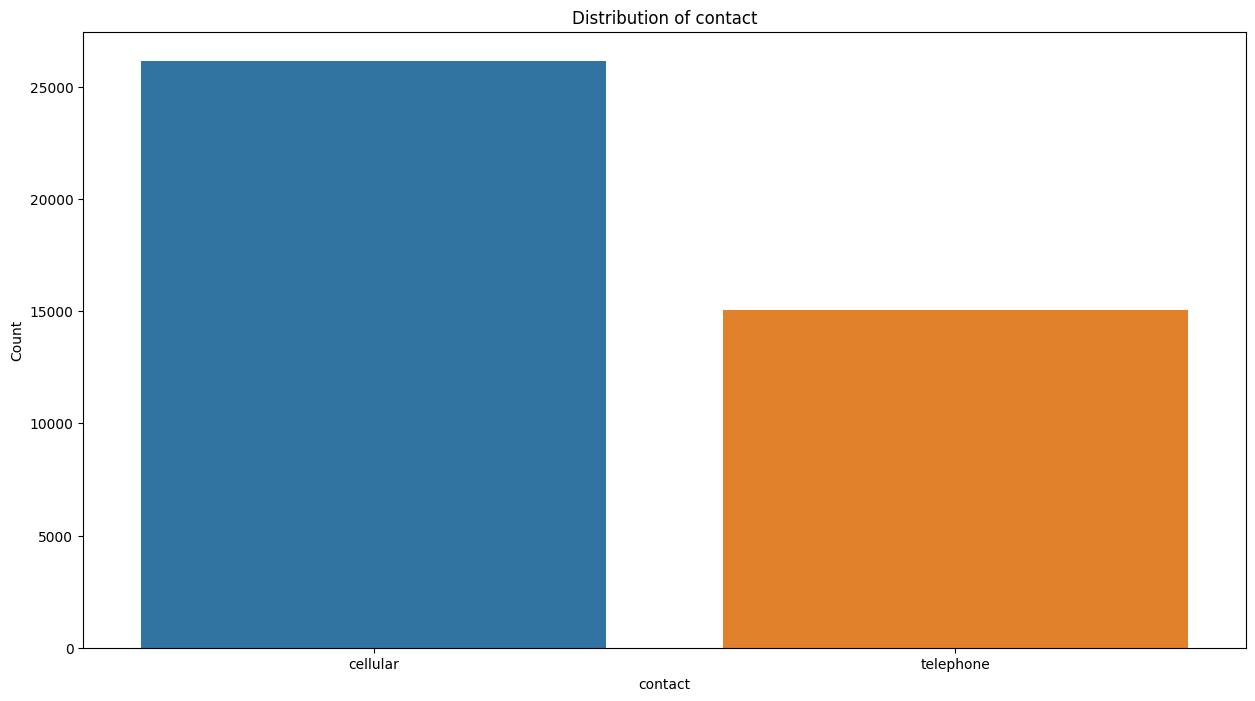

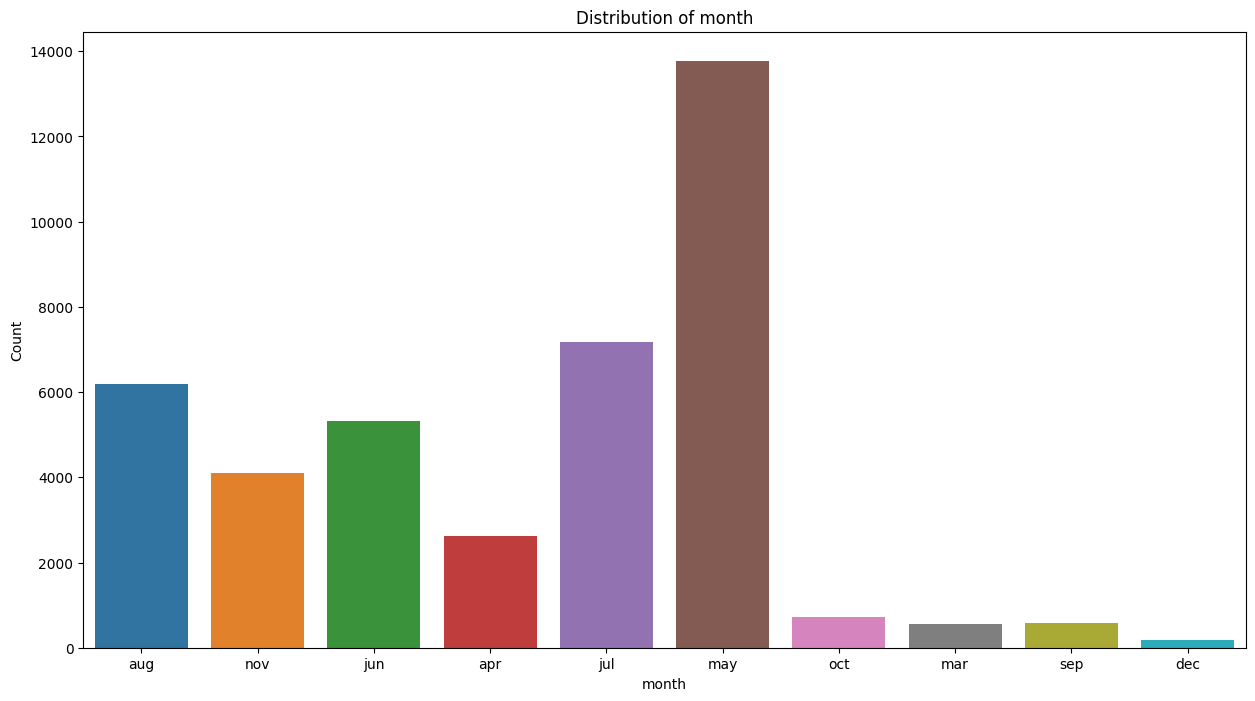

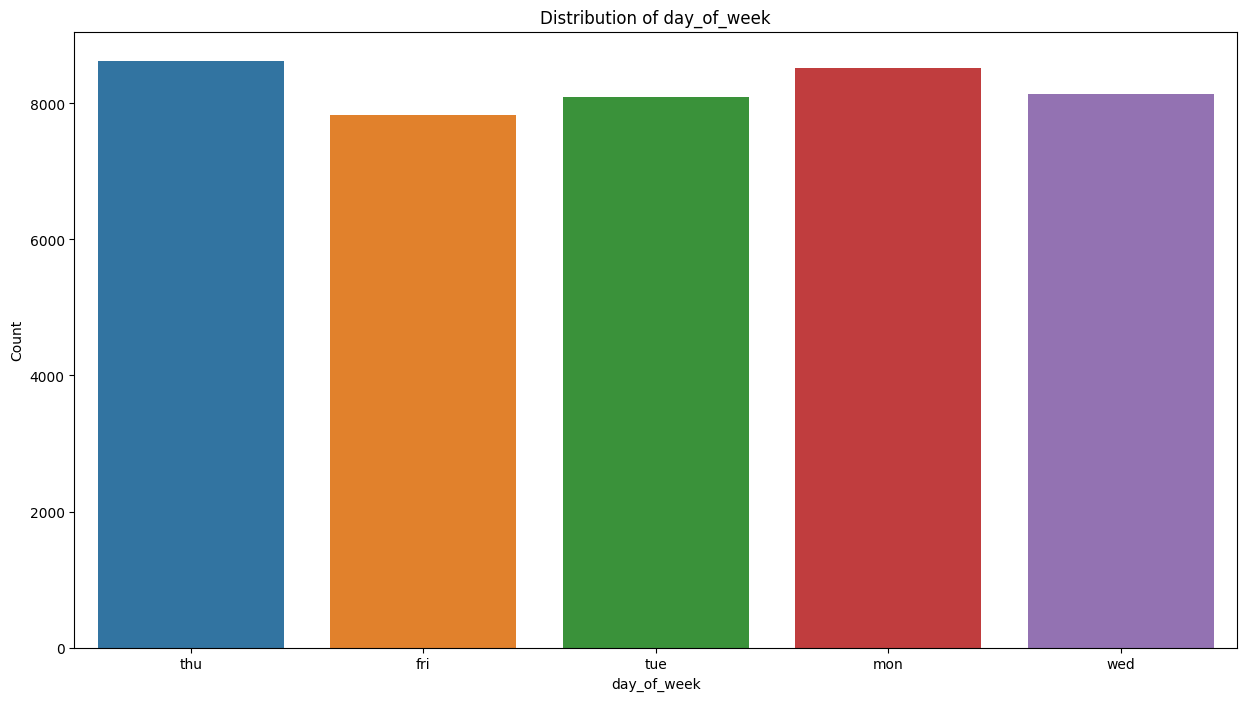

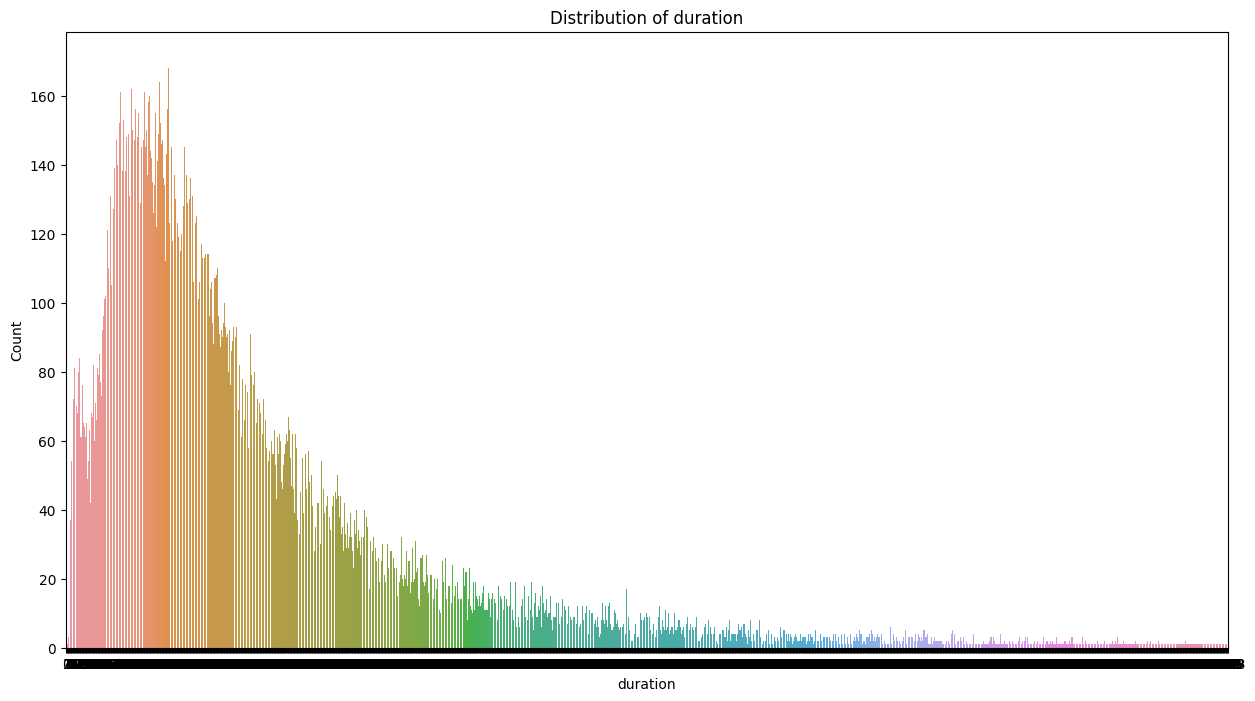

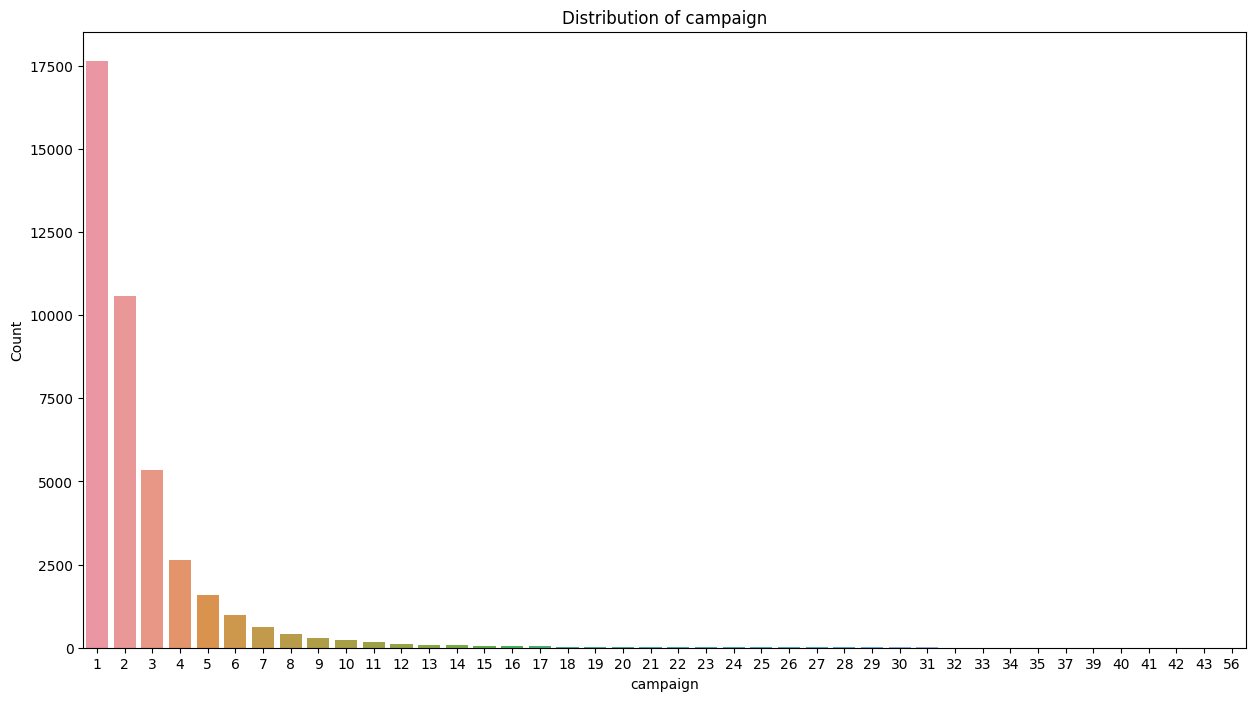

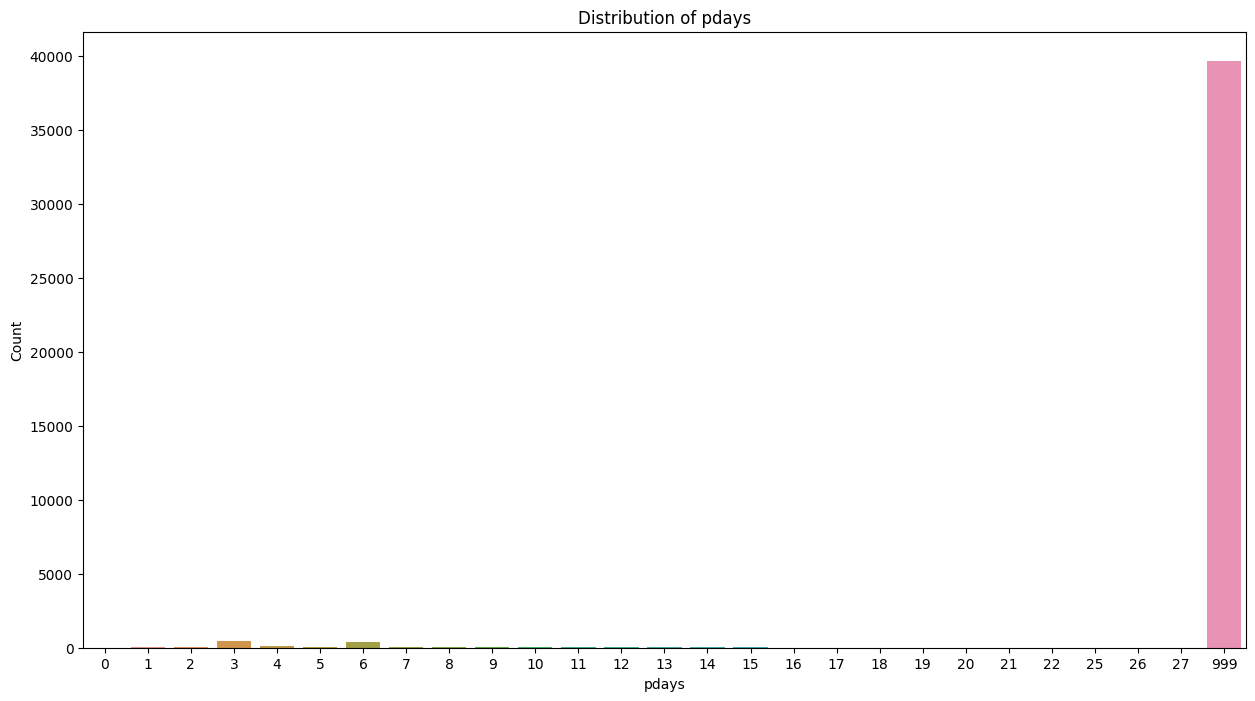

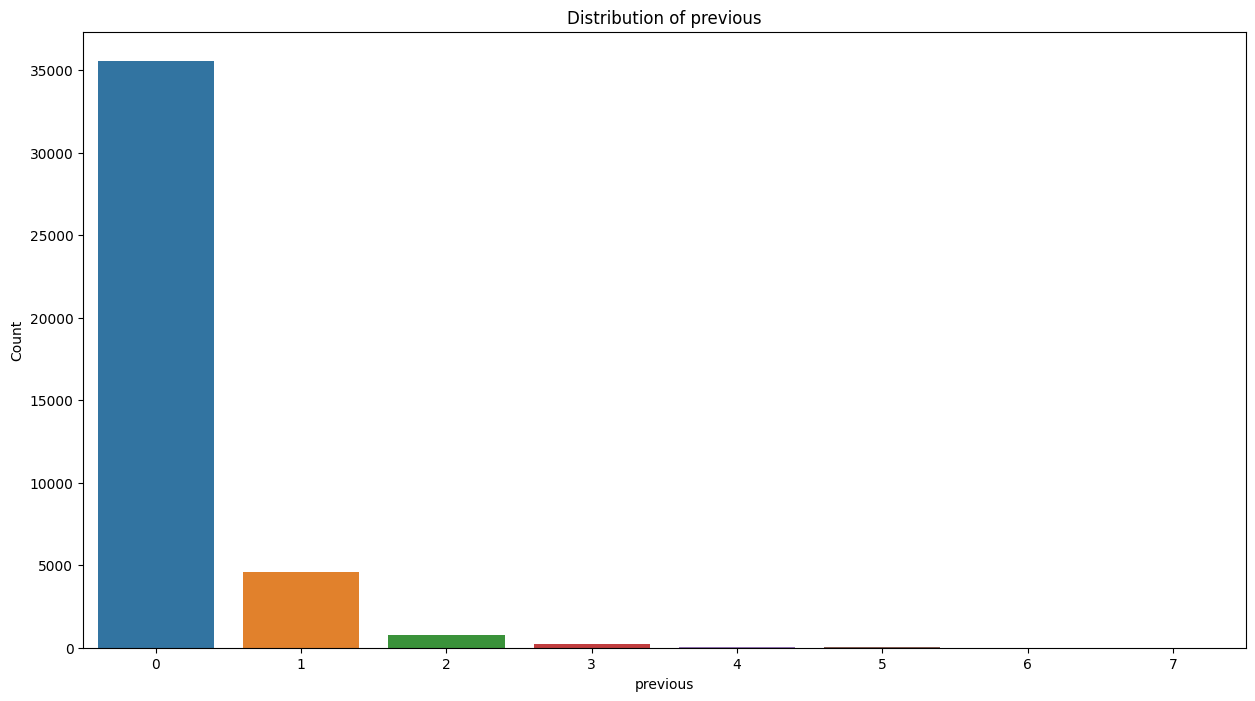

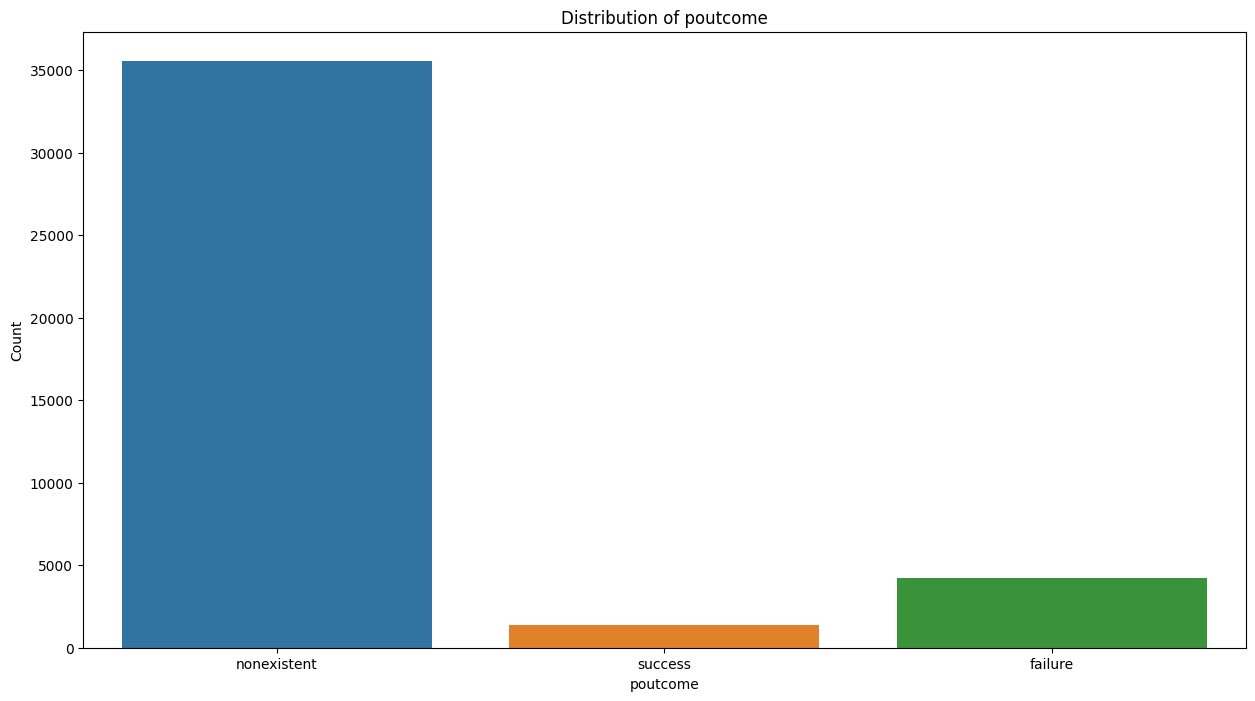

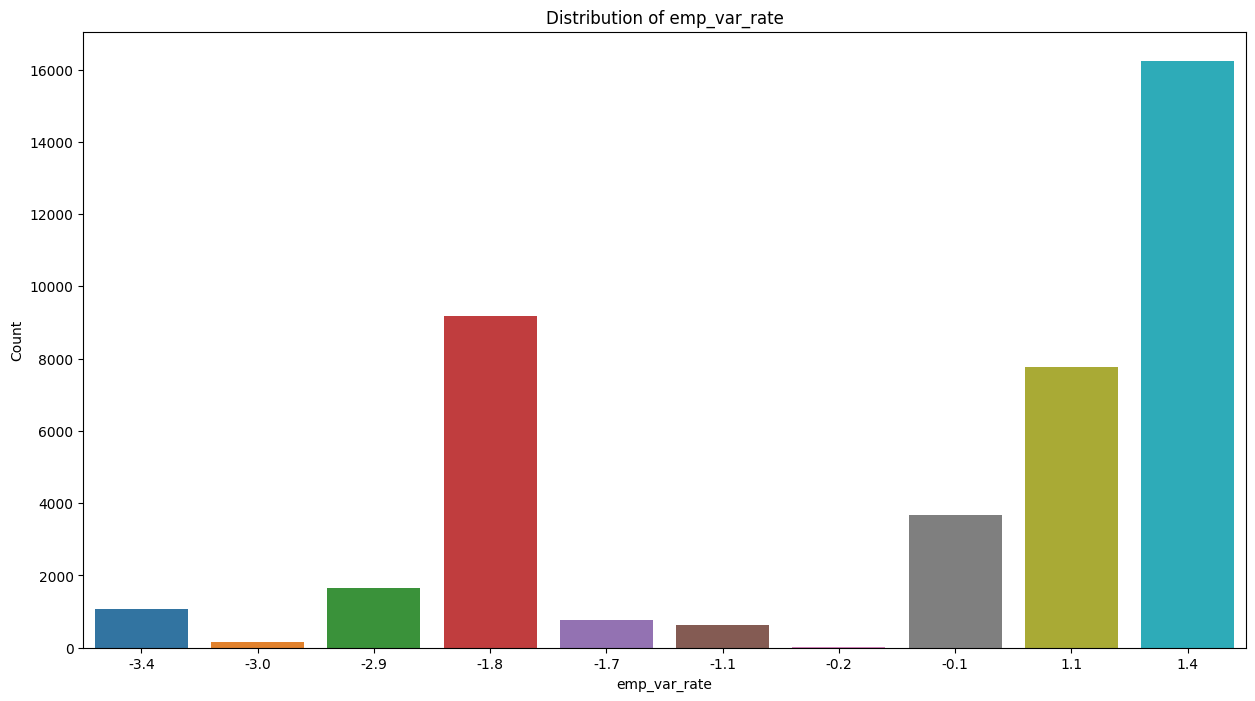

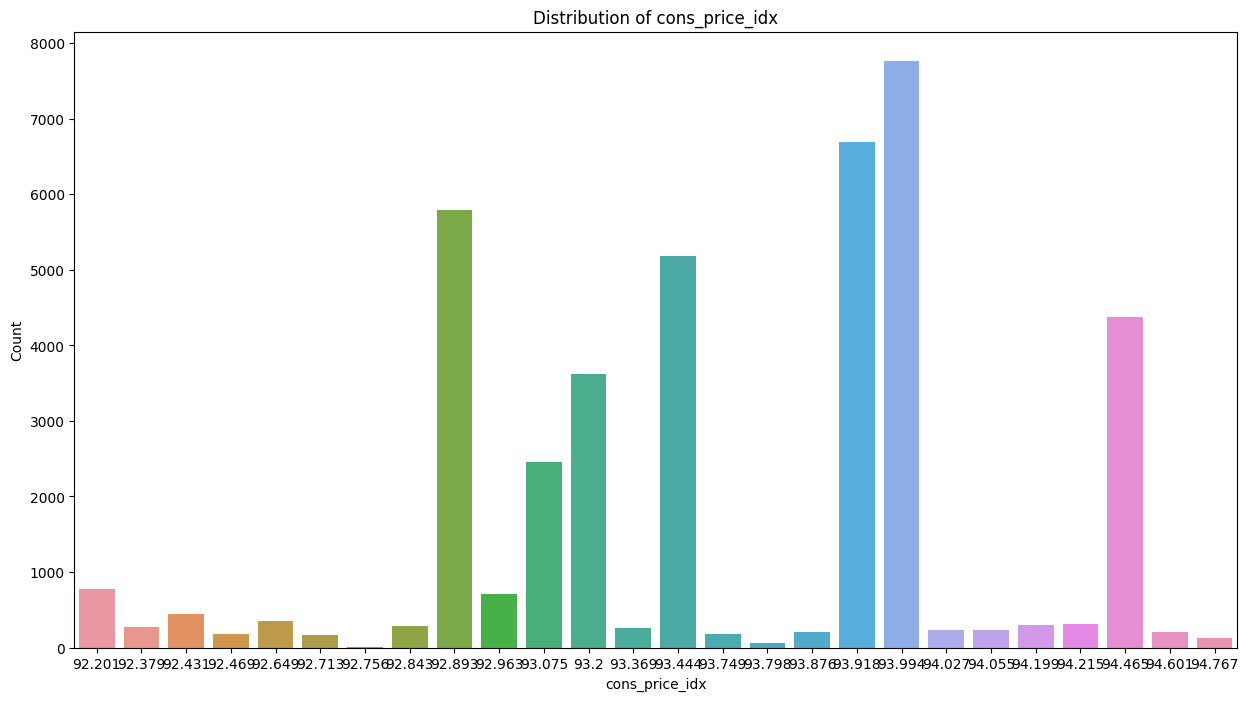

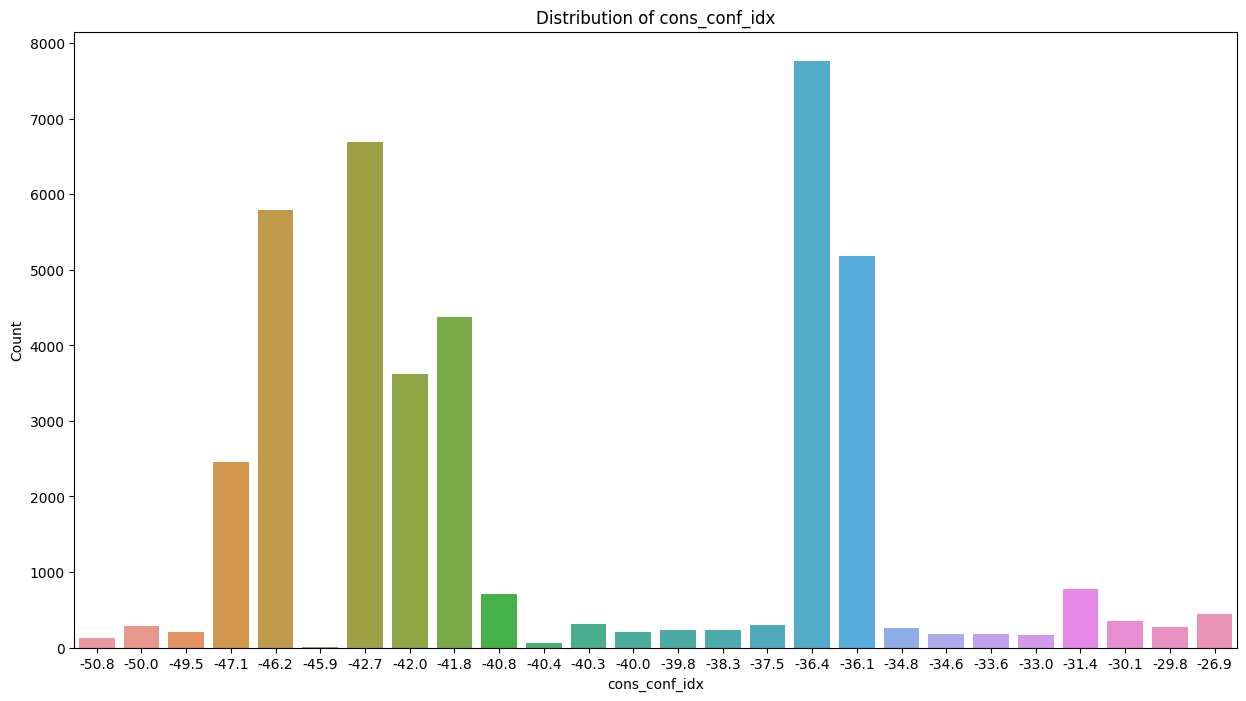

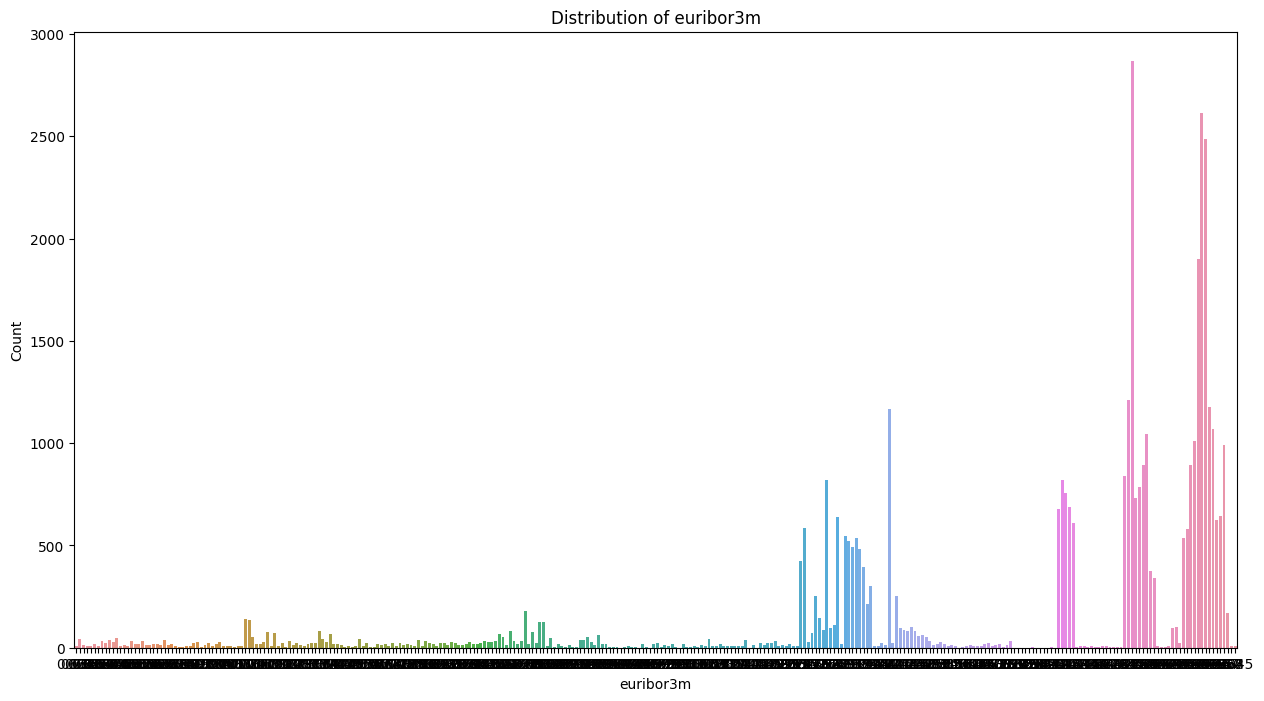

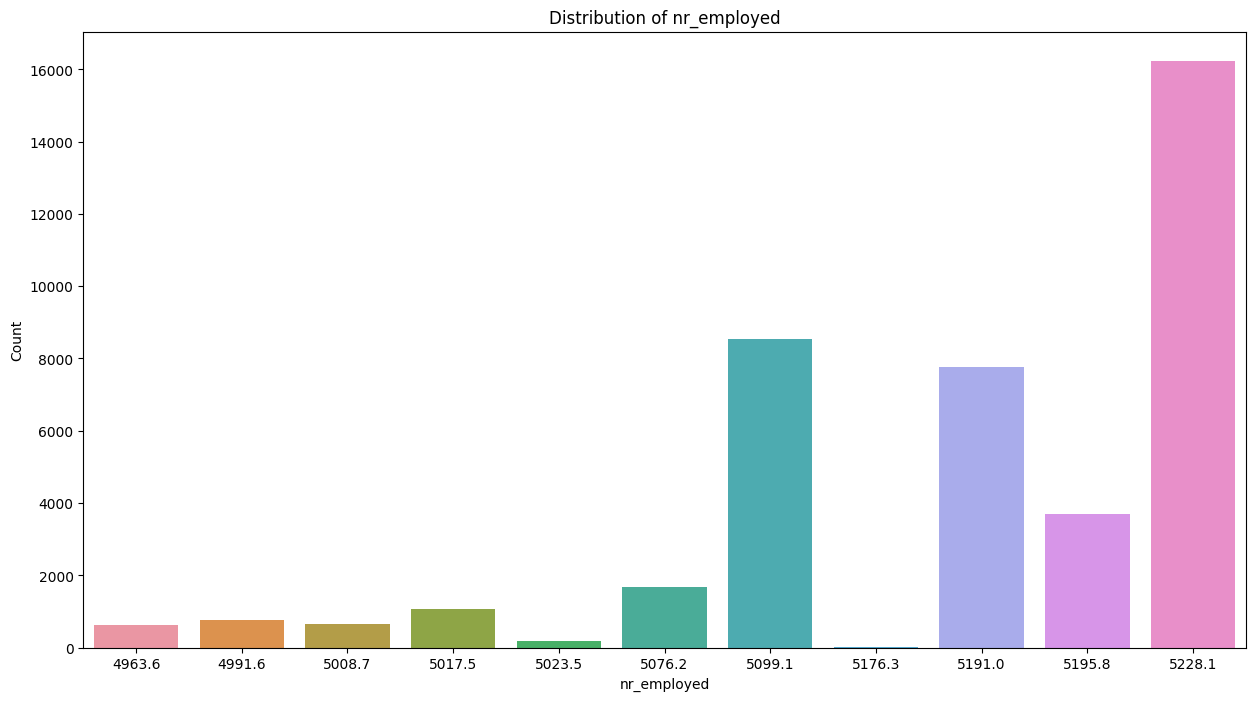

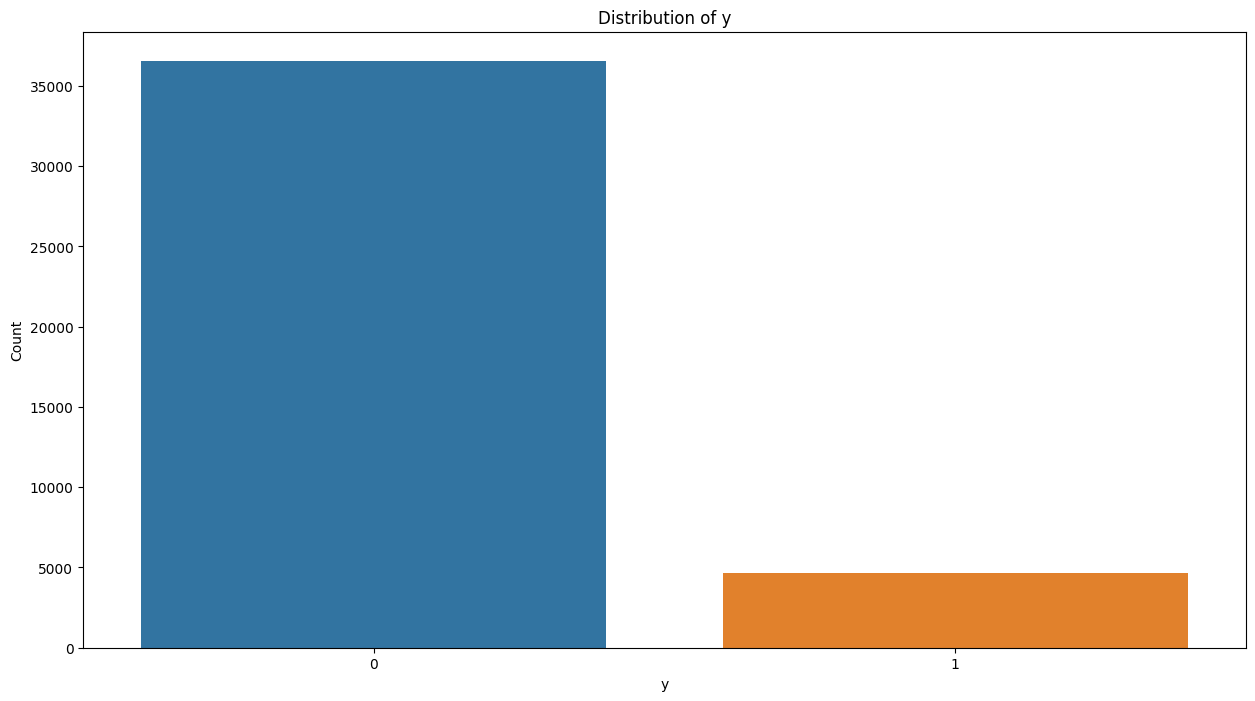

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

for column in df.columns:
    data = df.select(col(column)).toPandas()
    
    plt.figure(figsize=(15,8))
    sns.countplot(x=column, data=data)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title('Distribution of ' + column)
    plt.show()

In [14]:
num_cols = ['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

# Calculate the correlation matrix
corr_matrix = df.select(num_cols).toPandas().corr()

# Show the correlation matrix
corr_matrix

,age,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,-0.000371,0.000857,0.129372,0.010767,-0.017725
emp_var_rate,-0.000371,1.000000,0.775334,0.196041,0.972245,0.906970
cons_price_idx,0.000857,0.775334,1.000000,0.058986,0.688230,0.522034
cons_conf_idx,0.129372,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,0.972245,0.688230,0.277686,1.000000,0.945154
nr_employed,-0.017725,0.906970,0.522034,0.100513,0.945154,1.000000


# Check Missing Values

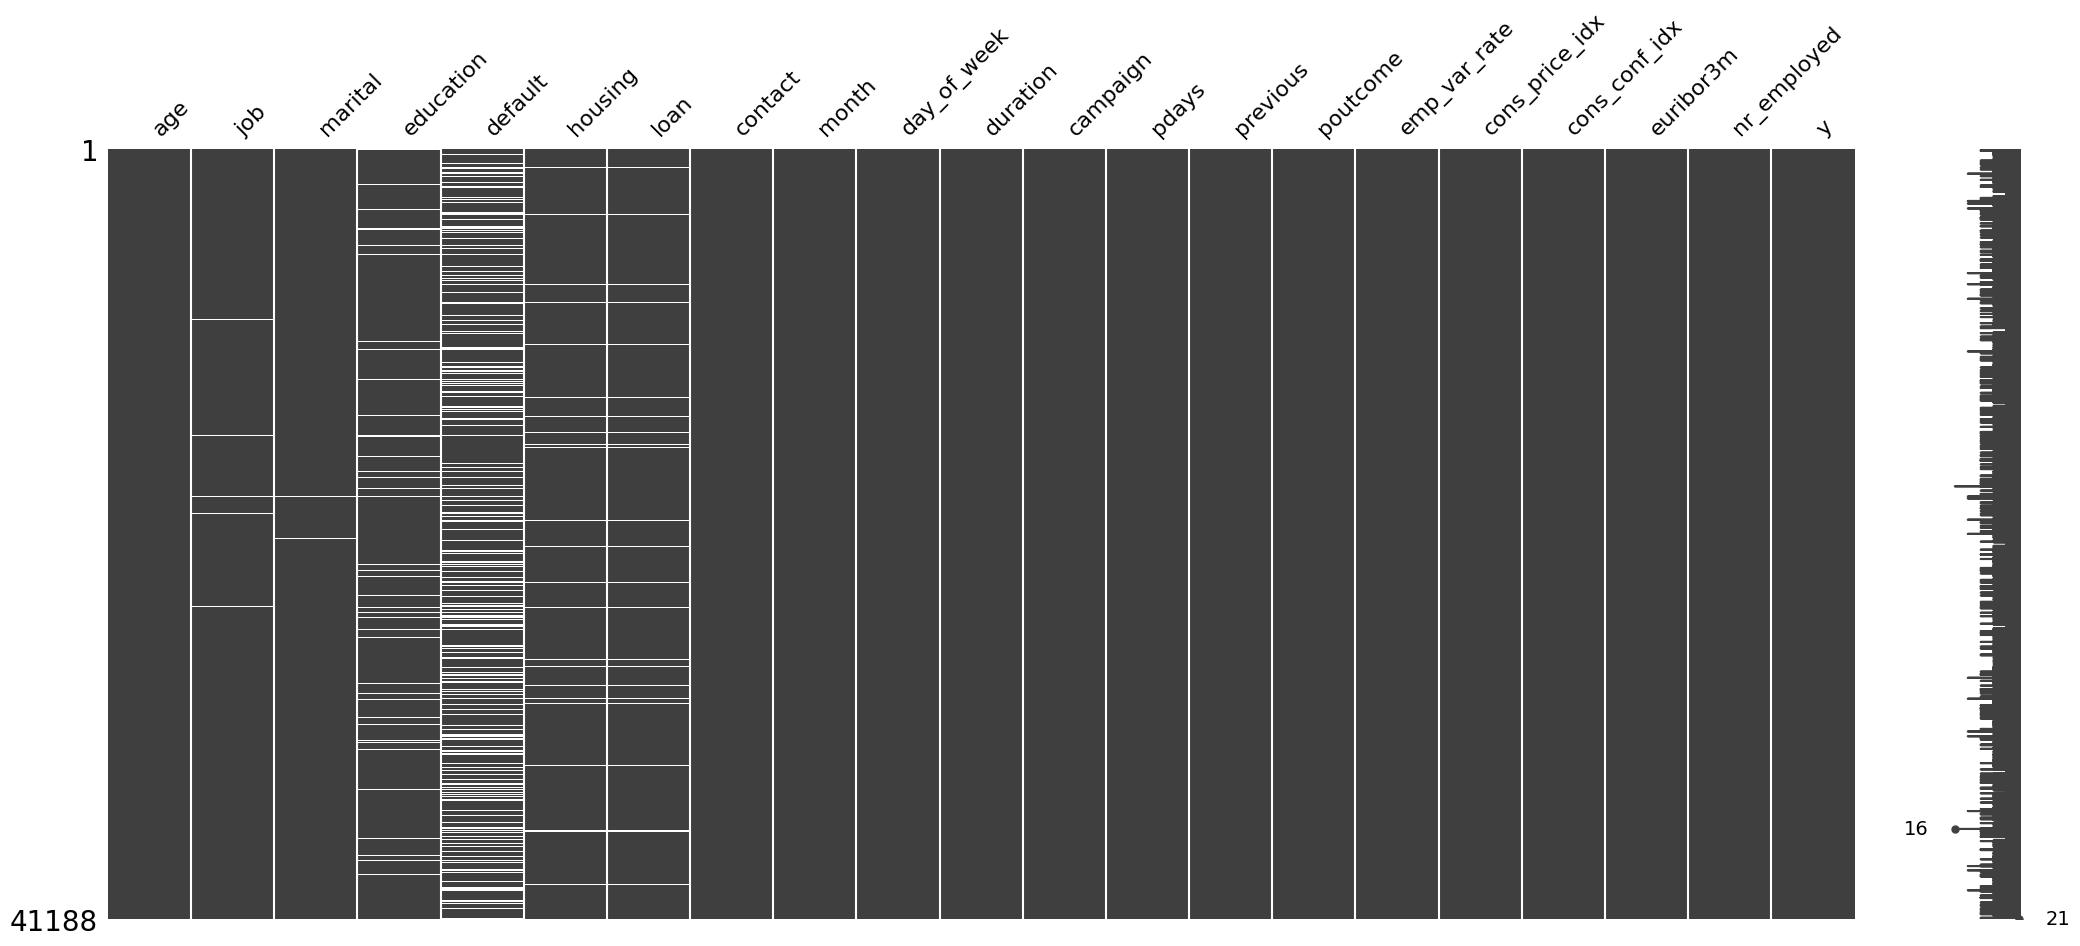

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,330,80,1731,8597,990,990,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
import missingno as msno
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

df = df.replace('unknown', None)


missing_df = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
missing = missing_df.toPandas().transpose()
missing.columns = ['count']
missing['percentage'] = (missing['count']/df.count())*100

# missing value heatmap
msno.matrix(df.toPandas())
plt.show()

missing_df.toPandas()

# preprocessing
### numeric columns -> z-score normalization (Mean and scale)
### categorical columns -> normalized by (Mode)

In [76]:
from pyspark.ml.feature import StringIndexer, Imputer
from pyspark.sql.functions import mean, when, col
from pyspark.sql.functions import col



cat_cols = ['job', 'marital', 'education', 'default', 'loan']
num_cols = ['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

#cat normalize
for col_name in cat_cols:
    df = df.withColumn(col_name, when(col(col_name) == 'unknown', None).otherwise(col(col_name)))

# Normalize cat cols with mode
for col_name in cat_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name+'_indexed', handleInvalid='skip')
    df = indexer.fit(df).transform(df)
    mode_value = df.groupBy(col_name).count().orderBy('count', ascending=False).first()[col_name]
    df = df.fillna(mode_value, subset=[col_name+'_indexed'])
    df = df.withColumnRenamed(col_name+'_indexed', col_name+'_normalized')
    
    
    
from pyspark.ml.feature import Imputer, StandardScaler
from pyspark.sql.functions import stddev, mean


# Impute missing values with mean
imputer = Imputer(inputCols=num_cols, outputCols=[c+'_imputed' for c in num_cols])
df = imputer.setStrategy('mean').fit(df).transform(df)

# Z-score normalization
for col in num_cols:
    col_mean = df.select(mean(col+'_imputed')).collect()[0][0]
    col_stddev = df.select(stddev(col+'_imputed')).collect()[0][0]
    df = df.withColumn(col+'_normalized', (df[col+'_imputed'] - col_mean) / col_stddev)
    
# Drop imputed columns
df = df.drop(*[c+'_imputed' for c in num_cols])

norm_df = df.select([
    'job_normalized',
    'marital_normalized',
    'education_normalized',
    'default_normalized',
    'loan_normalized',
    'age_normalized',
    'emp_var_rate_normalized',
    'cons_price_idx_normalized',
    'cons_conf_idx_normalized',
    'euribor3m_normalized',
    'nr_employed_normalized',
    'y'
])

norm_df.toPandas()

,job_normalized,marital_normalized,education_normalized,default_normalized,loan_normalized,age_normalized,emp_var_rate_normalized,cons_price_idx_normalized,cons_conf_idx_normalized,euribor3m_normalized,nr_employed_normalized,y
0,4.0,1.0,0.0,0.0,0.0,-1.067400,-1.011233,0.908289,0.167513,-1.536625,-2.251434,1
1,3.0,0.0,1.0,0.0,0.0,-0.002904,-1.073330,-0.765854,-1.356734,-1.156258,-0.821115,0
2,5.0,0.0,4.0,0.0,0.0,1.545453,-1.756390,-2.258916,1.921442,-1.457851,-1.125806,1
3,4.0,2.0,4.0,0.0,0.0,-0.873856,0.913755,0.674250,-0.438010,0.844607,0.895268,0
4,1.0,0.0,4.0,0.0,0.0,-0.196449,-1.073330,-1.076766,-1.168813,-1.200146,-0.821115,0
...,...,...,...,...,...,...,...,...,...,...,...,...
30483,2.0,1.0,2.0,0.0,0.0,-0.970628,-1.073330,-1.076766,-1.168813,-1.215901,-0.821115,0
30484,0.0,0.0,0.0,0.0,0.0,-0.002904,-0.017691,-0.552315,-0.291849,0.389968,0.465507,0
30485,0.0,0.0,1.0,0.0,0.0,-1.454490,-1.073330,-1.076766,-1.168813,-1.234470,-0.821115,0
30486,2.0,0.0,3.0,0.0,1.0,0.868047,-2.066872,-1.866005,2.861046,-1.529310,-1.906827,0


In [38]:
missing_df = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
missing_df.toPandas()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,marital_normalized,education_normalized,default_normalized,loan_normalized,age_normalized,emp_var_rate_normalized,cons_price_idx_normalized,cons_conf_idx_normalized,euribor3m_normalized,nr_employed_normalized
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
df.toPandas()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,marital_normalized,education_normalized,default_normalized,loan_normalized,age_normalized,emp_var_rate_normalized,cons_price_idx_normalized,cons_conf_idx_normalized,euribor3m_normalized,nr_employed_normalized
0,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,1.0,0.0,0.0,0.0,-1.067400,-1.011233,0.908289,0.167513,-1.536625,-2.251434
1,39,services,married,high.school,no,no,no,cellular,apr,fri,...,0.0,1.0,0.0,0.0,-0.002904,-1.073330,-0.765854,-1.356734,-1.156258,-0.821115
2,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,0.0,4.0,0.0,0.0,1.545453,-1.756390,-2.258916,1.921442,-1.457851,-1.125806
3,30,management,divorced,basic.4y,no,yes,no,cellular,jul,tue,...,2.0,4.0,0.0,0.0,-0.873856,0.913755,0.674250,-0.438010,0.844607,0.895268
4,37,blue-collar,married,basic.4y,no,yes,no,cellular,may,thu,...,0.0,4.0,0.0,0.0,-0.196449,-1.073330,-1.076766,-1.168813,-1.200146,-0.821115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,29,technician,single,basic.9y,no,yes,no,cellular,may,mon,...,1.0,2.0,0.0,0.0,-0.970628,-1.073330,-1.076766,-1.168813,-1.215901,-0.821115
30484,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,0.0,0.0,0.0,0.0,-0.002904,-0.017691,-0.552315,-0.291849,0.389968,0.465507
30485,24,admin.,married,high.school,no,yes,no,cellular,may,thu,...,0.0,1.0,0.0,0.0,-1.454490,-1.073330,-1.076766,-1.168813,-1.234470,-0.821115
30486,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,...,0.0,3.0,0.0,1.0,0.868047,-2.066872,-1.866005,2.861046,-1.529310,-1.906827


### feature selection
#### Chi-squared

In [77]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator


#convert the selected features into a single vector:
assembler = VectorAssembler(inputCols=['job_normalized', 'marital_normalized', 'education_normalized', 'default_normalized', 'loan_normalized', 'age_normalized', 'emp_var_rate_normalized', 'cons_price_idx_normalized', 'cons_conf_idx_normalized', 'euribor3m_normalized', 'nr_employed_normalized'], outputCol='features')

chi_df = assembler.transform(norm_df)

selector = ChiSqSelector(featuresCol='features', outputCol='selected_features', labelCol='y', selectorType='fpr', fpr=0.05)
model = selector.fit(chi_df)
chi_df = model.transform(chi_df)

chi_df.toPandas()

,job_normalized,marital_normalized,education_normalized,default_normalized,loan_normalized,age_normalized,emp_var_rate_normalized,cons_price_idx_normalized,cons_conf_idx_normalized,euribor3m_normalized,nr_employed_normalized,y,features,selected_features
0,4.0,1.0,0.0,0.0,0.0,-1.067400,-1.011233,0.908289,0.167513,-1.536625,-2.251434,1,"[4.0, 1.0, 0.0, 0.0, 0.0, -1.067400262149468, ...","[4.0, 1.0, 0.0, -1.067400262149468, -1.0112334..."
1,3.0,0.0,1.0,0.0,0.0,-0.002904,-1.073330,-0.765854,-1.356734,-1.156258,-0.821115,0,"[3.0, 0.0, 1.0, 0.0, 0.0, -0.00290431344988248...","[3.0, 0.0, 1.0, -0.0029043134498824823, -1.073..."
2,5.0,0.0,4.0,0.0,0.0,1.545453,-1.756390,-2.258916,1.921442,-1.457851,-1.125806,1,"[5.0, 0.0, 4.0, 0.0, 0.0, 1.545453430113151, -...","[5.0, 0.0, 4.0, 1.545453430113151, -1.75639022..."
3,4.0,2.0,4.0,0.0,0.0,-0.873856,0.913755,0.674250,-0.438010,0.844607,0.895268,0,"[4.0, 2.0, 4.0, 0.0, 0.0, -0.8738555442040888,...","[4.0, 2.0, 4.0, -0.8738555442040888, 0.9137547..."
4,1.0,0.0,4.0,0.0,0.0,-0.196449,-1.073330,-1.076766,-1.168813,-1.200146,-0.821115,0,"[1.0, 0.0, 4.0, 0.0, 0.0, -0.19644903139526168...","[1.0, 0.0, 4.0, -0.19644903139526168, -1.07332..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,2.0,1.0,2.0,0.0,0.0,-0.970628,-1.073330,-1.076766,-1.168813,-1.215901,-0.821115,0,"[2.0, 1.0, 2.0, 0.0, 0.0, -0.9706279031767785,...","[2.0, 1.0, 2.0, -0.9706279031767785, -1.073329..."
30484,0.0,0.0,0.0,0.0,0.0,-0.002904,-0.017691,-0.552315,-0.291849,0.389968,0.465507,0,"(0.0, 0.0, 0.0, 0.0, 0.0, -0.00290431344988248...","(0.0, 0.0, 0.0, -0.0029043134498824823, -0.017..."
30485,0.0,0.0,1.0,0.0,0.0,-1.454490,-1.073330,-1.076766,-1.168813,-1.234470,-0.821115,0,"[0.0, 0.0, 1.0, 0.0, 0.0, -1.4544896980402264,...","[0.0, 0.0, 1.0, -1.4544896980402264, -1.073329..."
30486,2.0,0.0,3.0,0.0,1.0,0.868047,-2.066872,-1.866005,2.861046,-1.529310,-1.906827,0,"[2.0, 0.0, 3.0, 0.0, 1.0, 0.8680469173043239, ...","[2.0, 0.0, 3.0, 0.8680469173043239, -2.0668721..."


In [78]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator


#convert the selected features into a single vector:
assembler = VectorAssembler(inputCols=['job_normalized', 'marital_normalized', 'education_normalized', 'default_normalized', 'loan_normalized', 'age_normalized', 'emp_var_rate_normalized', 'cons_price_idx_normalized', 'cons_conf_idx_normalized', 'euribor3m_normalized', 'nr_employed_normalized'], outputCol='features')

df = assembler.transform(df)

selector = ChiSqSelector(featuresCol='features', outputCol='selected_features', labelCol='y', selectorType='fpr', fpr=0.05)
model = selector.fit(df)
df = model.transform(df)

df.toPandas()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,default_normalized,loan_normalized,age_normalized,emp_var_rate_normalized,cons_price_idx_normalized,cons_conf_idx_normalized,euribor3m_normalized,nr_employed_normalized,features,selected_features
0,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,0.0,0.0,-1.067400,-1.011233,0.908289,0.167513,-1.536625,-2.251434,"[4.0, 1.0, 0.0, 0.0, 0.0, -1.067400262149468, ...","[4.0, 1.0, 0.0, -1.067400262149468, -1.0112334..."
1,39,services,married,high.school,no,no,no,cellular,apr,fri,...,0.0,0.0,-0.002904,-1.073330,-0.765854,-1.356734,-1.156258,-0.821115,"[3.0, 0.0, 1.0, 0.0, 0.0, -0.00290431344988248...","[3.0, 0.0, 1.0, -0.0029043134498824823, -1.073..."
2,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,0.0,0.0,1.545453,-1.756390,-2.258916,1.921442,-1.457851,-1.125806,"[5.0, 0.0, 4.0, 0.0, 0.0, 1.545453430113151, -...","[5.0, 0.0, 4.0, 1.545453430113151, -1.75639022..."
3,30,management,divorced,basic.4y,no,yes,no,cellular,jul,tue,...,0.0,0.0,-0.873856,0.913755,0.674250,-0.438010,0.844607,0.895268,"[4.0, 2.0, 4.0, 0.0, 0.0, -0.8738555442040888,...","[4.0, 2.0, 4.0, -0.8738555442040888, 0.9137547..."
4,37,blue-collar,married,basic.4y,no,yes,no,cellular,may,thu,...,0.0,0.0,-0.196449,-1.073330,-1.076766,-1.168813,-1.200146,-0.821115,"[1.0, 0.0, 4.0, 0.0, 0.0, -0.19644903139526168...","[1.0, 0.0, 4.0, -0.19644903139526168, -1.07332..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,29,technician,single,basic.9y,no,yes,no,cellular,may,mon,...,0.0,0.0,-0.970628,-1.073330,-1.076766,-1.168813,-1.215901,-0.821115,"[2.0, 1.0, 2.0, 0.0, 0.0, -0.9706279031767785,...","[2.0, 1.0, 2.0, -0.9706279031767785, -1.073329..."
30484,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,0.0,0.0,-0.002904,-0.017691,-0.552315,-0.291849,0.389968,0.465507,"(0.0, 0.0, 0.0, 0.0, 0.0, -0.00290431344988248...","(0.0, 0.0, 0.0, -0.0029043134498824823, -0.017..."
30485,24,admin.,married,high.school,no,yes,no,cellular,may,thu,...,0.0,0.0,-1.454490,-1.073330,-1.076766,-1.168813,-1.234470,-0.821115,"[0.0, 0.0, 1.0, 0.0, 0.0, -1.4544896980402264,...","[0.0, 0.0, 1.0, -1.4544896980402264, -1.073329..."
30486,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,...,0.0,1.0,0.868047,-2.066872,-1.866005,2.861046,-1.529310,-1.906827,"[2.0, 0.0, 3.0, 0.0, 1.0, 0.8680469173043239, ...","[2.0, 0.0, 3.0, 0.8680469173043239, -2.0668721..."


## Split the data


In [79]:
# Split the data into training and test sets
train_data, test_data = chi_df.randomSplit([0.7, 0.3], seed=86)

## SVM

In [71]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# Create the LinearSVC model
svm = LinearSVC(maxIter=10, regParam=0.1, featuresCol='selected_features', labelCol='y')

# Fit the SVM model on the training data
svm_model = svm.fit(train_data)

# Make predictions on the test data
predictions = svm_model.transform(test_data)

# Evaluate the performance of the model
evaluator = BinaryClassificationEvaluator(labelCol='y', rawPredictionCol='prediction')
auc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})



## LogisticRegression

In [80]:
lr = LogisticRegression(featuresCol='selected_features', labelCol='y', maxIter=10, regParam=0.01, elasticNetParam=0.01)
model = lr.fit(train_data)

predictions = model.transform(test_data)

## Evaluation SVM

### BinaryClassificationEvaluator
### f1, accuracy, precision, recall

In [72]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='y', predictionCol='prediction', metricName='weightedPrecision')
precision = evaluator.evaluate(predictions)

evaluator.setMetricName('weightedRecall')
recall = evaluator.evaluate(predictions)

evaluator.setMetricName('f1')
f1_score = evaluator.evaluate(predictions)



# Calculate accuracy
accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: 'accuracy'})
print('Accuracy:', accuracy)


# Calculate precision
print('Precision:', precision)

# Calculate recall
print('Recall:', recall)

# Calculate F1 score
print('F1 Score:', f1_score)

Accuracy: 0.8760151597184623
Precision: 0.767402560056563
Recall: 0.8760151597184623
F1 Score: 0.8181197855263908


## Evaluation Linear Regression
### BinaryClassificationEvaluator
### f1, accuracy, precision, recall

In [82]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


# Train a logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='y')
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Define evaluators
binary_evaluator = BinaryClassificationEvaluator(labelCol='y', rawPredictionCol='rawPrediction')
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol='y', predictionCol='prediction')


# Calculate accuracy
accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: 'accuracy'})
print('Accuracy:', accuracy)

# Calculate precision
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: 'weightedPrecision'})
print('Precision:', precision)

# Calculate recall
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: 'weightedRecall'})
print('Recall:', recall)

# Calculate F1 score
f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: 'f1'})
print('F1 Score:', f1_score)


Accuracy: 0.8749323226854359
Precision: 0.8386125576765984
Recall: 0.8749323226854359
F1 Score: 0.8424972291842017


# Points
## 1-correct missing values before normalize (deletion missed records by default)
## 2-missing values can replace by KNN and mode in categorical type
## 3-data seed for same test dataset